In [ ]:
# Uninstall any existing TensorFlow
!pip uninstall tensorflow -y

# Install TensorFlow 2.17
!pip install tensorflow==2.17.0

# Install Keras, Keras Tuner, and other required libraries
!pip install keras keras-tuner scikit-learn matplotlib scikit-image imblearn

# Verify the installation
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

print("TensorFlow version:", tf.__version__)
print("Keras Tuner version:", kt.__version__)



Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00
TensorFlow version: 2.17.0
Keras Tuner version: 1.4.7


In [ ]:
!pip install imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 76.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load images and labels
def load_images_and_labels(folder_path, image_size=(224, 224)):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            image = imread(file_path)
            if image is not None:
                image = resize(image, image_size, anti_aliasing=True)
                # Normalize the image
                image =normalize_image(image)

                images.append(image)
                label = file.rsplit('_', 1)[0]
                labels.append(label)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return np.array(images), np.array(labels)


In [ ]:
def normalize_image(image):
    # Normalize the image to scale pixel values to [0, 1]
    return image / 255.0


In [ ]:
def compute_mean_std(images):
    mean, variance = tf.nn.moments(images, axes=[0, 1, 2])
    stddev = tf.sqrt(variance) + 1e-7  # Add small constant to avoid division by zero
    return mean, stddev


In [ ]:
def standardize_images(images, mean, stddev):
    return (images - mean) / stddev


In [ ]:
# Load dataset
folder_path ='/content/drive/MyDrive/Colab Notebooks/Model/Data/Mendeley/classificacao_binaria/images_new'

images, labels = load_images_and_labels(folder_path)

# Check the shape of images and labels
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)




Shape of images: (7919, 224, 224, 3)
Shape of labels: (7919,)


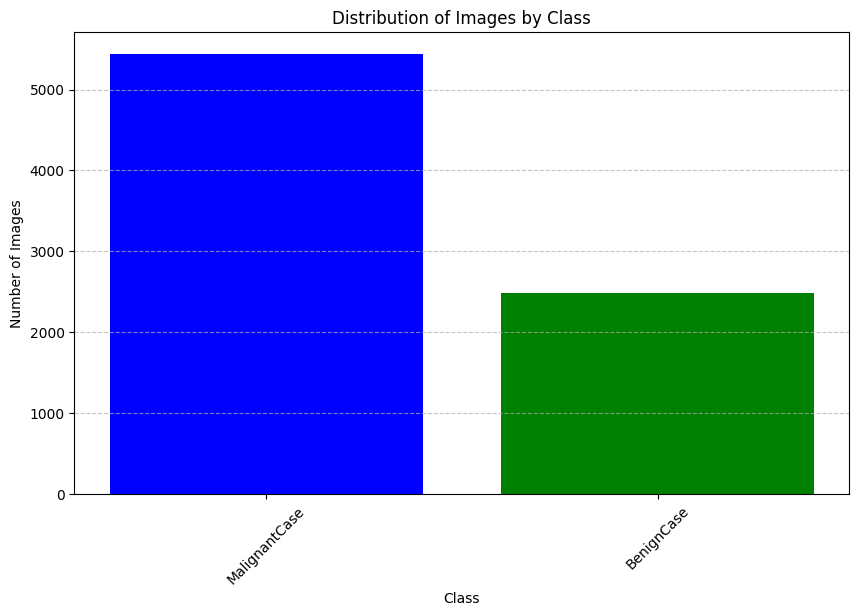

In [ ]:
# Count the number of samples in each class
class_counts = Counter(labels)

# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color=['blue', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images by Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Compute mean and stddev from the dataset
mean, stddev = compute_mean_std(images)
# Convert tensors to NumPy arrays
mean_np = mean.numpy()
stddev_np = stddev.numpy()

# Save to files
np.save('mean.npy', mean_np)
np.save('stddev.npy', stddev_np)
print("Mean:", mean_np)
print("Stddev:", stddev_np)

# Standardize images using computed mean and stddev
standardized_images_np =standardize_images(images, mean_np, stddev_np)


Mean: [0.00308388 0.00245429 0.00299549]
Stddev: [0.00050341 0.00070119 0.00044395]


In [ ]:
# Split the dataset
img_train, img_test, lbl_train, lbl_test = train_test_split(
    standardized_images_np, labels, test_size=0.2, random_state=42
)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_train_encoded = label_encoder.fit_transform(lbl_train)
lbl_test_encoded = label_encoder.transform(lbl_test)

num_classes = len(label_encoder.classes_)

In [ ]:

# Count the number of samples in each class before augmentation
unique, counts = np.unique(lbl_train_encoded, return_counts=True)
class_distribution_before = dict(zip(unique, counts))
# Assign counts to specific variables based on the class labels
count_class_0 = counts[unique == 0][0] if 0 in unique else 0
count_class_1 = counts[unique == 1][0] if 1 in unique else 0

print("Class distribution before augmentation:", dict(zip(unique, counts)))
print(f"Number of samples in Class 0: {count_class_0}")
print(f"Number of samples in Class 1: {count_class_1}")


Class distribution before augmentation: {0: 1990, 1: 4345}
Number of samples in Class 0: 1990
Number of samples in Class 1: 4345


In [ ]:
# Data augmentation for minority class

mindatagen = ImageDataGenerator(
    rotation_range=20,            # Increase rotation range
    width_shift_range=0.02,        # Increase width shift range
    height_shift_range=0.02,       # Increase height shift range
    zoom_range=0.2,               # Increase zoom range
    horizontal_flip=True,         # Keep horizontal flip
    brightness_range=[0.8, 1.2],  # Vary brightness
    fill_mode='nearest'
)

batch_size = 32

# Get minority class samples
minority_images = img_train[lbl_train_encoded == 0]
minority_labels = lbl_train_encoded[lbl_train_encoded == 0]

# Create a data generator for the minority class
minority_generator = mindatagen.flow(
    minority_images,
    minority_labels,
    batch_size=32
)
additional_samples_needed = int(0.05 * count_class_1)  # 5% more of majority class

# Calculate total samples needed for the minority class (existing + additional)
n_samples_needed = additional_samples_needed + count_class_1 - count_class_0

#augmenting and appending data
augmented_images = []
augmented_labels = []
for _ in range(n_samples_needed // batch_size + 1):  # Generate more samples
    imgs, lbls = next(minority_generator)
    augmented_images.append(imgs)
    augmented_labels.append(lbls)

augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

# Append to the original dataset
img_train_augmented = np.concatenate([img_train, augmented_images])
lbl_train_encoded_augmented = np.concatenate([lbl_train_encoded, augmented_labels])


Class distribution after augmentation: {0: 4556, 1: 4345}


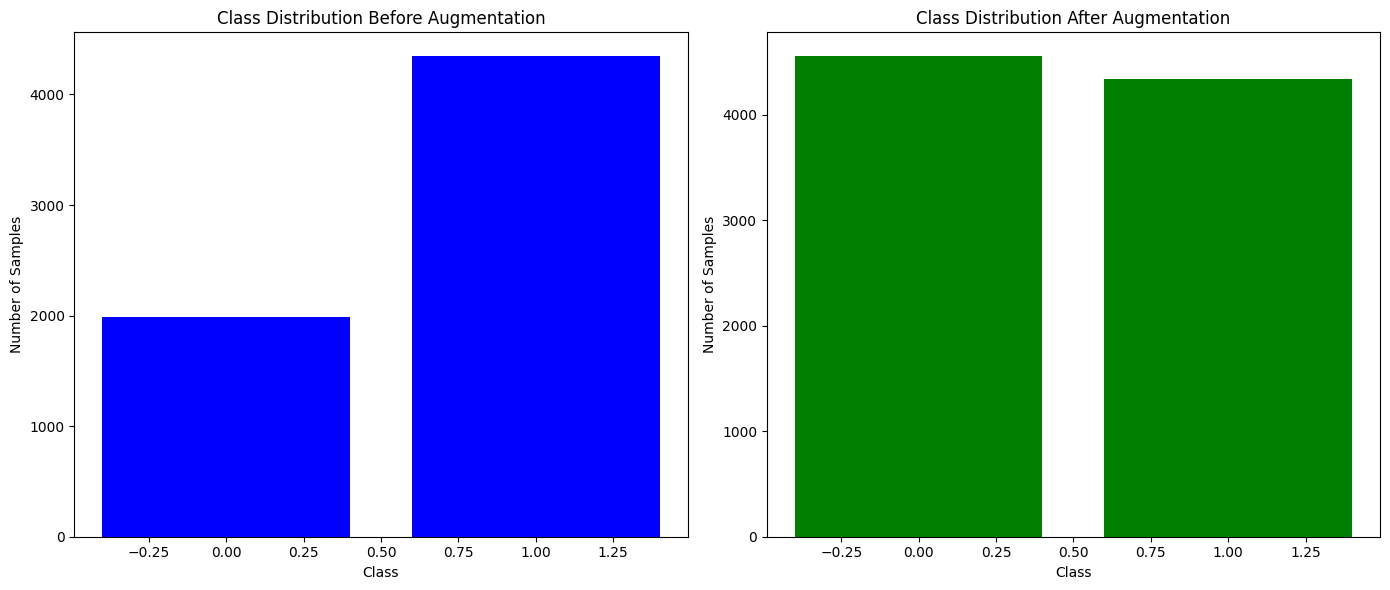

In [ ]:
# Count the number of samples in each class after augmentation
unique_aug, counts_aug = np.unique(lbl_train_encoded_augmented, return_counts=True)
class_distribution_after = dict(zip(unique_aug, counts_aug))
print("Class distribution after augmentation:", class_distribution_after)

# Plotting the class distribution before and after augmentation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot before augmentation
ax[0].bar(class_distribution_before.keys(), class_distribution_before.values(), color='blue')
ax[0].set_title('Class Distribution Before Augmentation')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Samples')

# Plot after augmentation
ax[1].bar(class_distribution_after.keys(), class_distribution_after.values(), color='green')
ax[1].set_title('Class Distribution After Augmentation')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()